# Time as a Decision Variable

It often that time is an important decision variable in process optimization. Questions like "when will the concentration reach peak value?", or "how fast can this separation be done?", or "when will the temperature reach the target value?" are situations where the time becomes a decision variable or even the primary objective for optimization. 

The purpose of this notebook is to demonstrate how rescaling time can be useful in problems like these. This is not a universal solution for all problems involving time, but it definitely should be part of your modeling toolkit.

In [11]:
import pyomo.environ as pyo
import pyomo.dae as dae

k1 =  1
k2 = 0.5

IC = 1.0

m = pyo.ConcreteModel()

m.tau = dae.ContinuousSet(bounds=(0, 1))
m.C = pyo.Var(m.tau, domain=pyo.NonNegativeReals)
m.tf = pyo.Var(domain=pyo.NonNegativeReals)

m.dCdt = dae.DerivativeVar(m.C)

@m.Constraint(m.tau)
def ode_model(m, tau):
    return m.dCdt[tau] == -m.tf * k1 * m.C[tau]/(k2 + m.C[tau])

m.C[0].fix(IC)
m.C[1].fix(IC/2)

pyo.TransformationFactory('dae.finite_difference').apply_to(m, nfe=100, scheme='FORWARD')
pyo.SolverFactory('ipopt').solve(m)
print(m.tf())

0.845358661704921


$$\frac{dC}{dt} = - \frac{k_1 C}{k_2 + C}$$

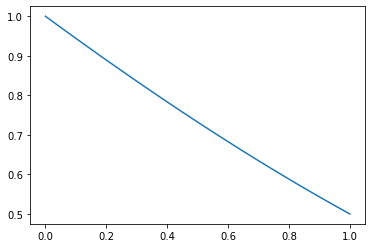

In [8]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(m.tau, [m.C[tau]() for tau in m.tau])

In [9]:
import pyomo.environ as pyo
import pyomo.dae as dae

k1 =  1
k2 = 0.5

IC = 1.0

m = pyo.ConcreteModel()

m.t = dae.ContinuousSet(bounds=(0, 5))
m.C = pyo.Var(m.t, domain=pyo.NonNegativeReals)

m.dCdt = dae.DerivativeVar(m.C)

@m.Constraint(m.t)
def ode_model(m, t):
    return m.dCdt[t] == - k1 * m.C[t]/(k2 + m.C[t])

m.C[0].fix(IC)


pyo.TransformationFactory('dae.finite_difference').apply_to(m, nfe=100, scheme='FORWARD')
pyo.SolverFactory('ipopt').solve(m)

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 201, 'Number of variables': 201, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.13.4\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.41997814178466797}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

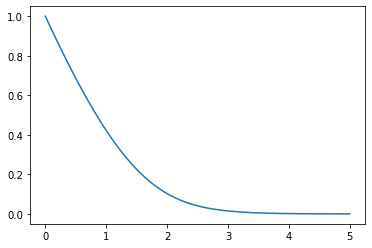

In [10]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(m.t, [m.C[t]() for t in m.t])